Importing libraries

In [4]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [5]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [6]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/VERA/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 2200 files belonging to 110 classes.
Using 1760 files for training.
Using 440 files for validation.

Total number of samples in train_dataset: 1408 (44 batches of 32)
Total number of samples in validation_dataset: 448 (14 batches of 32)
Total number of samples in test_dataset: 352 (11 batches of 32)


Prefetching data into GPU memory to optimize training process

In [7]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

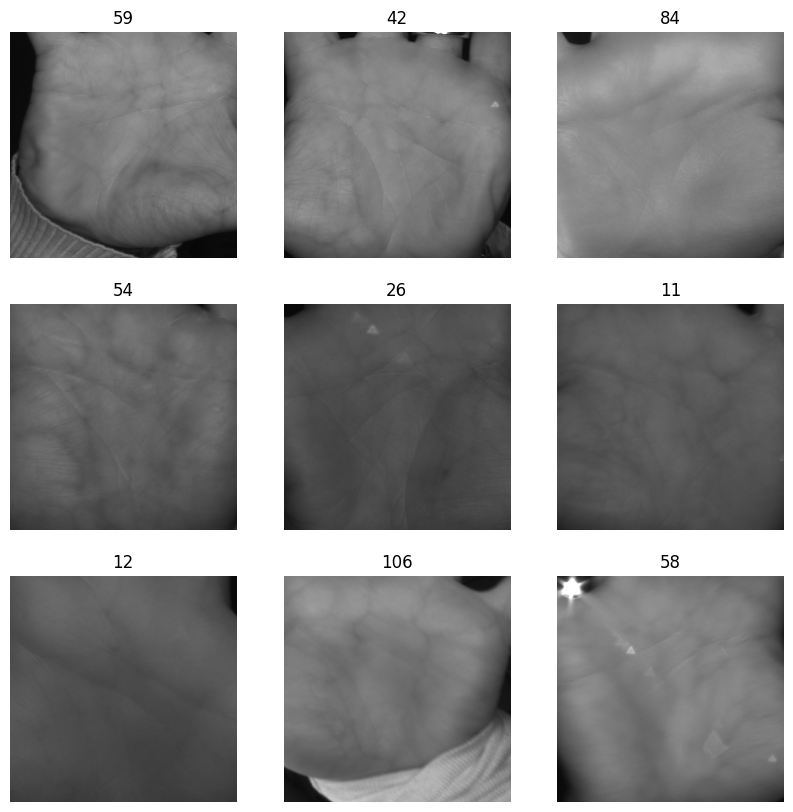

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Creating data augmentation layer 

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
    ]
)

Visualizing the data augmentations on a random training image

In [10]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_dataset.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

Define some key constants

In [11]:
num_classes = 110
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [12]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [13]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [14]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [15]:
from tqdm import tqdm
num_epochs = 30

models = {
    "AlexNet": make_alexnet_model(input_shape=image_size, num_classes=num_classes),
    "VGG16": make_vgg16_model(input_shape=image_size, num_classes=num_classes),
    "VGG19": make_vgg19_model(input_shape=image_size, num_classes=num_classes),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training AlexNet Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
42/44 [===========================>..] - ETA: 0s - loss: 4.6160 - accuracy: 0.0253

  3%|▎         | 1/30 [00:11<05:36, 11.60s/it]

44/44 [==============================] - 12s 59ms/step - loss: 4.6053 - accuracy: 0.0270 - val_loss: 5.0584 - val_accuracy: 0.0091
Epoch 2/30
43/44 [============================>.] - ETA: 0s - loss: 4.0918 - accuracy: 0.0618

  7%|▋         | 2/30 [00:13<02:43,  5.85s/it]

44/44 [==============================] - 2s 37ms/step - loss: 4.0877 - accuracy: 0.0611 - val_loss: 4.8381 - val_accuracy: 0.0091
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 3.7353 - accuracy: 0.0987

 10%|█         | 3/30 [00:15<01:47,  3.97s/it]

44/44 [==============================] - 2s 36ms/step - loss: 3.7353 - accuracy: 0.0987 - val_loss: 4.3879 - val_accuracy: 0.0364
Epoch 4/30
42/44 [===========================>..] - ETA: 0s - loss: 3.4059 - accuracy: 0.1667

 13%|█▎        | 4/30 [00:17<01:22,  3.18s/it]

44/44 [==============================] - 2s 41ms/step - loss: 3.4076 - accuracy: 0.1655 - val_loss: 3.7850 - val_accuracy: 0.1159
Epoch 5/30
43/44 [============================>.] - ETA: 0s - loss: 3.1480 - accuracy: 0.2108

 17%|█▋        | 5/30 [00:18<01:06,  2.64s/it]

44/44 [==============================] - 2s 36ms/step - loss: 3.1467 - accuracy: 0.2102 - val_loss: 3.3156 - val_accuracy: 0.2159
Epoch 6/30
43/44 [============================>.] - ETA: 0s - loss: 2.8274 - accuracy: 0.2740

 20%|██        | 6/30 [00:20<00:55,  2.31s/it]

44/44 [==============================] - 2s 34ms/step - loss: 2.8346 - accuracy: 0.2734 - val_loss: 2.9937 - val_accuracy: 0.3023
Epoch 7/30
43/44 [============================>.] - ETA: 0s - loss: 2.5811 - accuracy: 0.3328

 23%|██▎       | 7/30 [00:22<00:48,  2.11s/it]

44/44 [==============================] - 2s 36ms/step - loss: 2.5894 - accuracy: 0.3288 - val_loss: 2.8711 - val_accuracy: 0.3023
Epoch 8/30
43/44 [============================>.] - ETA: 0s - loss: 2.2284 - accuracy: 0.3953

 27%|██▋       | 8/30 [00:23<00:43,  1.96s/it]

44/44 [==============================] - 2s 34ms/step - loss: 2.2215 - accuracy: 0.3949 - val_loss: 3.6055 - val_accuracy: 0.1500
Epoch 9/30
43/44 [============================>.] - ETA: 0s - loss: 1.9902 - accuracy: 0.4651

 30%|███       | 9/30 [00:25<00:39,  1.89s/it]

44/44 [==============================] - 2s 36ms/step - loss: 1.9876 - accuracy: 0.4638 - val_loss: 2.5740 - val_accuracy: 0.3341
Epoch 10/30
43/44 [============================>.] - ETA: 0s - loss: 1.7192 - accuracy: 0.5283

 33%|███▎      | 10/30 [00:27<00:36,  1.84s/it]

44/44 [==============================] - 2s 35ms/step - loss: 1.7086 - accuracy: 0.5312 - val_loss: 2.8742 - val_accuracy: 0.2955
Epoch 11/30
43/44 [============================>.] - ETA: 0s - loss: 1.4865 - accuracy: 0.5887

 37%|███▋      | 11/30 [00:29<00:34,  1.81s/it]

44/44 [==============================] - 2s 37ms/step - loss: 1.4832 - accuracy: 0.5888 - val_loss: 3.0106 - val_accuracy: 0.2659
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 1.2398 - accuracy: 0.6555

 40%|████      | 12/30 [00:30<00:32,  1.79s/it]

44/44 [==============================] - 2s 36ms/step - loss: 1.2398 - accuracy: 0.6555 - val_loss: 4.6608 - val_accuracy: 0.1591
Epoch 13/30
43/44 [============================>.] - ETA: 0s - loss: 1.1086 - accuracy: 0.6773

 43%|████▎     | 13/30 [00:32<00:30,  1.78s/it]

44/44 [==============================] - 2s 36ms/step - loss: 1.1122 - accuracy: 0.6754 - val_loss: 2.9931 - val_accuracy: 0.3114
Epoch 14/30
43/44 [============================>.] - ETA: 0s - loss: 0.9048 - accuracy: 0.7391

 47%|████▋     | 14/30 [00:34<00:28,  1.77s/it]

44/44 [==============================] - 2s 36ms/step - loss: 0.9083 - accuracy: 0.7401 - val_loss: 3.1414 - val_accuracy: 0.3136
Epoch 15/30
43/44 [============================>.] - ETA: 0s - loss: 0.8122 - accuracy: 0.7783

 50%|█████     | 15/30 [00:36<00:27,  1.82s/it]

44/44 [==============================] - 2s 41ms/step - loss: 0.8187 - accuracy: 0.7784 - val_loss: 2.9119 - val_accuracy: 0.3659
Epoch 16/30
43/44 [============================>.] - ETA: 0s - loss: 0.6066 - accuracy: 0.8314

 53%|█████▎    | 16/30 [00:37<00:25,  1.79s/it]

44/44 [==============================] - 2s 36ms/step - loss: 0.6126 - accuracy: 0.8295 - val_loss: 1.5470 - val_accuracy: 0.6477
Epoch 17/30
43/44 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.8561

 57%|█████▋    | 17/30 [00:39<00:23,  1.78s/it]

44/44 [==============================] - 2s 36ms/step - loss: 0.5052 - accuracy: 0.8587 - val_loss: 1.3293 - val_accuracy: 0.6659
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.8722

 60%|██████    | 18/30 [00:41<00:21,  1.77s/it]

44/44 [==============================] - 2s 36ms/step - loss: 0.4563 - accuracy: 0.8722 - val_loss: 1.0162 - val_accuracy: 0.7591
Epoch 19/30
43/44 [============================>.] - ETA: 0s - loss: 0.3287 - accuracy: 0.9048

 63%|██████▎   | 19/30 [00:43<00:19,  1.76s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.3284 - accuracy: 0.9048 - val_loss: 1.0250 - val_accuracy: 0.7727
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9276

 67%|██████▋   | 20/30 [00:45<00:17,  1.78s/it]

44/44 [==============================] - 2s 39ms/step - loss: 0.2754 - accuracy: 0.9276 - val_loss: 1.2877 - val_accuracy: 0.7023
Epoch 21/30
43/44 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.9092

 70%|███████   | 21/30 [00:46<00:15,  1.77s/it]

44/44 [==============================] - 2s 36ms/step - loss: 0.3014 - accuracy: 0.9091 - val_loss: 1.0464 - val_accuracy: 0.7477
Epoch 22/30
43/44 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9397

 73%|███████▎  | 22/30 [00:48<00:14,  1.75s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.2238 - accuracy: 0.9382 - val_loss: 2.0157 - val_accuracy: 0.5432
Epoch 23/30
43/44 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9557

 77%|███████▋  | 23/30 [00:50<00:12,  1.74s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.1748 - accuracy: 0.9531 - val_loss: 0.7165 - val_accuracy: 0.8432
Epoch 24/30
43/44 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9513

 80%|████████  | 24/30 [00:51<00:10,  1.72s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.1821 - accuracy: 0.9510 - val_loss: 0.8410 - val_accuracy: 0.8159
Epoch 25/30
43/44 [============================>.] - ETA: 0s - loss: 0.1511 - accuracy: 0.9586

 83%|████████▎ | 25/30 [00:53<00:08,  1.72s/it]

44/44 [==============================] - 2s 36ms/step - loss: 0.1546 - accuracy: 0.9574 - val_loss: 0.7298 - val_accuracy: 0.8364
Epoch 26/30
43/44 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.9717

 87%|████████▋ | 26/30 [00:55<00:07,  1.79s/it]

44/44 [==============================] - 2s 40ms/step - loss: 0.0982 - accuracy: 0.9716 - val_loss: 0.7611 - val_accuracy: 0.8386
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9759

 90%|█████████ | 27/30 [01:05<00:12,  4.21s/it]

44/44 [==============================] - 10s 224ms/step - loss: 0.0956 - accuracy: 0.9759 - val_loss: 0.6345 - val_accuracy: 0.8545
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9751

 93%|█████████▎| 28/30 [01:14<00:11,  5.63s/it]

44/44 [==============================] - 9s 203ms/step - loss: 0.0822 - accuracy: 0.9751 - val_loss: 0.7244 - val_accuracy: 0.8295
Epoch 29/30
43/44 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9797

 97%|█████████▋| 29/30 [01:23<00:06,  6.66s/it]

44/44 [==============================] - 9s 206ms/step - loss: 0.0783 - accuracy: 0.9794 - val_loss: 0.7187 - val_accuracy: 0.8432
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9822

100%|██████████| 30/30 [01:32<00:00,  7.25s/it]

44/44 [==============================] - 9s 195ms/step - loss: 0.0687 - accuracy: 0.9822 - val_loss: 0.6228 - val_accuracy: 0.8886


100%|██████████| 30/30 [01:32<00:00,  3.07s/it]


Finished training AlexNet in 92.03s

Training VGG16 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 5.8274 - accuracy: 0.0249

  3%|▎         | 1/30 [01:10<33:55, 70.20s/it]

44/44 [==============================] - 70s 1s/step - loss: 5.8274 - accuracy: 0.0249 - val_loss: 4.7322 - val_accuracy: 0.0023
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 4.2724 - accuracy: 0.0838

  7%|▋         | 2/30 [01:45<23:18, 49.94s/it]

44/44 [==============================] - 36s 822ms/step - loss: 4.2724 - accuracy: 0.0838 - val_loss: 4.7742 - val_accuracy: 0.0068
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 3.6559 - accuracy: 0.1712

 10%|█         | 3/30 [02:16<18:25, 40.95s/it]

44/44 [==============================] - 30s 695ms/step - loss: 3.6559 - accuracy: 0.1712 - val_loss: 4.8110 - val_accuracy: 0.0068
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 3.2058 - accuracy: 0.2415

 13%|█▎        | 4/30 [02:46<15:55, 36.74s/it]

44/44 [==============================] - 30s 648ms/step - loss: 3.2058 - accuracy: 0.2415 - val_loss: 4.7679 - val_accuracy: 0.0068
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 2.7175 - accuracy: 0.3310

 17%|█▋        | 5/30 [03:18<14:37, 35.11s/it]

44/44 [==============================] - 32s 697ms/step - loss: 2.7175 - accuracy: 0.3310 - val_loss: 4.6293 - val_accuracy: 0.0136
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 2.2355 - accuracy: 0.4247

 20%|██        | 6/30 [03:49<13:24, 33.51s/it]

44/44 [==============================] - 30s 698ms/step - loss: 2.2355 - accuracy: 0.4247 - val_loss: 4.5596 - val_accuracy: 0.0477
Epoch 7/30
44/44 [==============================] - ETA: 0s - loss: 1.7589 - accuracy: 0.5447

 23%|██▎       | 7/30 [04:19<12:27, 32.49s/it]

44/44 [==============================] - 30s 698ms/step - loss: 1.7589 - accuracy: 0.5447 - val_loss: 3.5792 - val_accuracy: 0.1614
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 1.3039 - accuracy: 0.6506

 27%|██▋       | 8/30 [04:52<11:54, 32.49s/it]

44/44 [==============================] - 32s 700ms/step - loss: 1.3039 - accuracy: 0.6506 - val_loss: 2.4730 - val_accuracy: 0.3795
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 1.1799 - accuracy: 0.6669

 30%|███       | 9/30 [05:22<11:07, 31.81s/it]

44/44 [==============================] - 30s 696ms/step - loss: 1.1799 - accuracy: 0.6669 - val_loss: 1.5715 - val_accuracy: 0.6341
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 0.8220 - accuracy: 0.7805

 33%|███▎      | 10/30 [05:52<10:26, 31.33s/it]

44/44 [==============================] - 30s 695ms/step - loss: 0.8220 - accuracy: 0.7805 - val_loss: 0.9804 - val_accuracy: 0.7864
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.8196

 37%|███▋      | 11/30 [06:22<09:49, 31.03s/it]

44/44 [==============================] - 30s 697ms/step - loss: 0.6518 - accuracy: 0.8196 - val_loss: 0.9736 - val_accuracy: 0.7591
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.8580

 40%|████      | 12/30 [06:55<09:25, 31.40s/it]

44/44 [==============================] - 32s 695ms/step - loss: 0.5218 - accuracy: 0.8580 - val_loss: 0.9978 - val_accuracy: 0.7591
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8956

 43%|████▎     | 13/30 [07:25<08:47, 31.05s/it]

44/44 [==============================] - 30s 695ms/step - loss: 0.3810 - accuracy: 0.8956 - val_loss: 0.5365 - val_accuracy: 0.8705
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9403

 47%|████▋     | 14/30 [07:55<08:13, 30.82s/it]

44/44 [==============================] - 30s 696ms/step - loss: 0.2572 - accuracy: 0.9403 - val_loss: 0.6326 - val_accuracy: 0.8477
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9489

 50%|█████     | 15/30 [08:26<07:40, 30.71s/it]

44/44 [==============================] - 30s 699ms/step - loss: 0.1920 - accuracy: 0.9489 - val_loss: 0.4481 - val_accuracy: 0.8977
Epoch 16/30
44/44 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9460

 53%|█████▎    | 16/30 [08:58<07:16, 31.18s/it]

44/44 [==============================] - 32s 697ms/step - loss: 0.1858 - accuracy: 0.9460 - val_loss: 0.4810 - val_accuracy: 0.8932
Epoch 17/30
44/44 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9553

 57%|█████▋    | 17/30 [09:26<06:33, 30.31s/it]

44/44 [==============================] - 28s 649ms/step - loss: 0.1728 - accuracy: 0.9553 - val_loss: 0.4015 - val_accuracy: 0.9068
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9524

 60%|██████    | 18/30 [09:40<05:04, 25.40s/it]

44/44 [==============================] - 14s 312ms/step - loss: 0.1804 - accuracy: 0.9524 - val_loss: 0.3968 - val_accuracy: 0.9136
Epoch 19/30
44/44 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9631

 63%|██████▎   | 19/30 [09:57<04:10, 22.79s/it]

44/44 [==============================] - 17s 377ms/step - loss: 0.1285 - accuracy: 0.9631 - val_loss: 0.4467 - val_accuracy: 0.9000
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9652

 67%|██████▋   | 20/30 [10:14<03:30, 21.00s/it]

44/44 [==============================] - 17s 375ms/step - loss: 0.1150 - accuracy: 0.9652 - val_loss: 0.4426 - val_accuracy: 0.9114
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9773

 70%|███████   | 21/30 [10:30<02:57, 19.69s/it]

44/44 [==============================] - 17s 372ms/step - loss: 0.0986 - accuracy: 0.9773 - val_loss: 0.4320 - val_accuracy: 0.8909
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9787

 73%|███████▎  | 22/30 [10:46<02:28, 18.60s/it]

44/44 [==============================] - 16s 361ms/step - loss: 0.0705 - accuracy: 0.9787 - val_loss: 0.4014 - val_accuracy: 0.9091
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9808

 77%|███████▋  | 23/30 [11:03<02:05, 17.90s/it]

44/44 [==============================] - 16s 365ms/step - loss: 0.0694 - accuracy: 0.9808 - val_loss: 0.3916 - val_accuracy: 0.9205
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9901

 80%|████████  | 24/30 [11:18<01:42, 17.14s/it]

44/44 [==============================] - 15s 345ms/step - loss: 0.0457 - accuracy: 0.9901 - val_loss: 0.4614 - val_accuracy: 0.8932
Epoch 25/30
44/44 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9872

 83%|████████▎ | 25/30 [11:35<01:24, 16.95s/it]

44/44 [==============================] - 17s 371ms/step - loss: 0.0518 - accuracy: 0.9872 - val_loss: 0.4246 - val_accuracy: 0.9136
Epoch 26/30
44/44 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9844

 87%|████████▋ | 26/30 [11:50<01:06, 16.60s/it]

44/44 [==============================] - 16s 354ms/step - loss: 0.0523 - accuracy: 0.9844 - val_loss: 0.3396 - val_accuracy: 0.9250
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9858

 90%|█████████ | 27/30 [12:07<00:50, 16.68s/it]

44/44 [==============================] - 17s 378ms/step - loss: 0.0468 - accuracy: 0.9858 - val_loss: 0.3872 - val_accuracy: 0.9136
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9922

 93%|█████████▎| 28/30 [12:23<00:33, 16.55s/it]

44/44 [==============================] - 16s 362ms/step - loss: 0.0369 - accuracy: 0.9922 - val_loss: 0.3157 - val_accuracy: 0.9318
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9865

 97%|█████████▋| 29/30 [12:39<00:16, 16.30s/it]

44/44 [==============================] - 16s 355ms/step - loss: 0.0522 - accuracy: 0.9865 - val_loss: 0.4140 - val_accuracy: 0.9159
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9915

100%|██████████| 30/30 [12:55<00:00, 16.04s/it]

44/44 [==============================] - 15s 348ms/step - loss: 0.0315 - accuracy: 0.9915 - val_loss: 0.4711 - val_accuracy: 0.8795


100%|██████████| 30/30 [12:55<00:00, 25.84s/it]


Finished training VGG16 in 775.11s

Training VGG19 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 5.9215 - accuracy: 0.0185

  3%|▎         | 1/30 [00:19<09:19, 19.31s/it]

44/44 [==============================] - 19s 398ms/step - loss: 5.9215 - accuracy: 0.0185 - val_loss: 4.7464 - val_accuracy: 0.0091
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 4.4294 - accuracy: 0.0668

  7%|▋         | 2/30 [00:36<08:32, 18.29s/it]

44/44 [==============================] - 18s 397ms/step - loss: 4.4294 - accuracy: 0.0668 - val_loss: 4.8328 - val_accuracy: 0.0023
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 4.0410 - accuracy: 0.1016

 10%|█         | 3/30 [00:54<08:07, 18.07s/it]

44/44 [==============================] - 18s 402ms/step - loss: 4.0410 - accuracy: 0.1016 - val_loss: 4.9046 - val_accuracy: 0.0023
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 3.8285 - accuracy: 0.1271

 13%|█▎        | 4/30 [01:12<07:48, 18.02s/it]

44/44 [==============================] - 18s 403ms/step - loss: 3.8285 - accuracy: 0.1271 - val_loss: 4.8912 - val_accuracy: 0.0068
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 3.4061 - accuracy: 0.1974

 17%|█▋        | 5/30 [01:30<07:26, 17.86s/it]

44/44 [==============================] - 18s 397ms/step - loss: 3.4061 - accuracy: 0.1974 - val_loss: 4.5913 - val_accuracy: 0.0205
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 3.1041 - accuracy: 0.2557

 20%|██        | 6/30 [01:47<07:04, 17.69s/it]

44/44 [==============================] - 17s 390ms/step - loss: 3.1041 - accuracy: 0.2557 - val_loss: 4.4617 - val_accuracy: 0.0455
Epoch 7/30
44/44 [==============================] - ETA: 0s - loss: 2.6666 - accuracy: 0.3310

 23%|██▎       | 7/30 [02:02<06:26, 16.81s/it]

44/44 [==============================] - 15s 336ms/step - loss: 2.6666 - accuracy: 0.3310 - val_loss: 3.9433 - val_accuracy: 0.1341
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 2.3281 - accuracy: 0.4119

 27%|██▋       | 8/30 [02:15<05:42, 15.55s/it]

44/44 [==============================] - 13s 289ms/step - loss: 2.3281 - accuracy: 0.4119 - val_loss: 3.7973 - val_accuracy: 0.1273
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 1.8874 - accuracy: 0.5291

 30%|███       | 9/30 [02:28<05:09, 14.73s/it]

44/44 [==============================] - 13s 291ms/step - loss: 1.8874 - accuracy: 0.5291 - val_loss: 3.9659 - val_accuracy: 0.1659
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 1.4216 - accuracy: 0.6335

 33%|███▎      | 10/30 [02:41<04:43, 14.18s/it]

44/44 [==============================] - 13s 291ms/step - loss: 1.4216 - accuracy: 0.6335 - val_loss: 3.4611 - val_accuracy: 0.1886
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 1.1289 - accuracy: 0.6982

 37%|███▋      | 11/30 [02:54<04:21, 13.78s/it]

44/44 [==============================] - 13s 290ms/step - loss: 1.1289 - accuracy: 0.6982 - val_loss: 1.8782 - val_accuracy: 0.5455
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.7734

 40%|████      | 12/30 [03:07<04:02, 13.50s/it]

44/44 [==============================] - 13s 289ms/step - loss: 0.8718 - accuracy: 0.7734 - val_loss: 1.5965 - val_accuracy: 0.5932
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 0.7041 - accuracy: 0.8054

 43%|████▎     | 13/30 [03:19<03:45, 13.29s/it]

44/44 [==============================] - 13s 289ms/step - loss: 0.7041 - accuracy: 0.8054 - val_loss: 1.3987 - val_accuracy: 0.6227
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.8629

 47%|████▋     | 14/30 [03:32<03:30, 13.17s/it]

44/44 [==============================] - 13s 290ms/step - loss: 0.5064 - accuracy: 0.8629 - val_loss: 1.7233 - val_accuracy: 0.5568
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8885

 50%|█████     | 15/30 [03:45<03:16, 13.09s/it]

44/44 [==============================] - 13s 291ms/step - loss: 0.3874 - accuracy: 0.8885 - val_loss: 2.1655 - val_accuracy: 0.4545
Epoch 16/30
44/44 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8949

 53%|█████▎    | 16/30 [03:58<03:02, 13.02s/it]

44/44 [==============================] - 13s 289ms/step - loss: 0.3790 - accuracy: 0.8949 - val_loss: 1.4711 - val_accuracy: 0.6318
Epoch 17/30
44/44 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.9155

 57%|█████▋    | 17/30 [04:11<02:48, 13.00s/it]

44/44 [==============================] - 13s 291ms/step - loss: 0.3012 - accuracy: 0.9155 - val_loss: 0.5235 - val_accuracy: 0.8841
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9609

 60%|██████    | 18/30 [04:24<02:35, 12.97s/it]

44/44 [==============================] - 13s 291ms/step - loss: 0.1528 - accuracy: 0.9609 - val_loss: 0.4186 - val_accuracy: 0.9000
Epoch 19/30
44/44 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9510

 63%|██████▎   | 19/30 [04:37<02:22, 12.98s/it]

44/44 [==============================] - 13s 293ms/step - loss: 0.1773 - accuracy: 0.9510 - val_loss: 0.7116 - val_accuracy: 0.8205
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9688

 67%|██████▋   | 20/30 [04:50<02:09, 12.97s/it]

44/44 [==============================] - 13s 291ms/step - loss: 0.1202 - accuracy: 0.9688 - val_loss: 0.3284 - val_accuracy: 0.9227
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9688

 70%|███████   | 21/30 [05:03<01:56, 12.95s/it]

44/44 [==============================] - 13s 290ms/step - loss: 0.1351 - accuracy: 0.9688 - val_loss: 0.5030 - val_accuracy: 0.8886
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9666

 73%|███████▎  | 22/30 [05:16<01:43, 12.95s/it]

44/44 [==============================] - 13s 292ms/step - loss: 0.1293 - accuracy: 0.9666 - val_loss: 0.4450 - val_accuracy: 0.8955
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9794

 77%|███████▋  | 23/30 [05:29<01:30, 12.95s/it]

44/44 [==============================] - 13s 290ms/step - loss: 0.0966 - accuracy: 0.9794 - val_loss: 1.0833 - val_accuracy: 0.7295
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9652

 80%|████████  | 24/30 [05:41<01:17, 12.93s/it]

44/44 [==============================] - 13s 290ms/step - loss: 0.1240 - accuracy: 0.9652 - val_loss: 0.8120 - val_accuracy: 0.8023
Epoch 25/30
44/44 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9751

 83%|████████▎ | 25/30 [05:54<01:04, 12.91s/it]

44/44 [==============================] - 13s 290ms/step - loss: 0.0882 - accuracy: 0.9751 - val_loss: 0.3272 - val_accuracy: 0.9205
Epoch 26/30
44/44 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9815

 87%|████████▋ | 26/30 [06:07<00:51, 12.92s/it]

44/44 [==============================] - 13s 291ms/step - loss: 0.0655 - accuracy: 0.9815 - val_loss: 0.6728 - val_accuracy: 0.8114
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9893

 90%|█████████ | 27/30 [06:20<00:38, 12.90s/it]

44/44 [==============================] - 13s 289ms/step - loss: 0.0464 - accuracy: 0.9893 - val_loss: 0.3883 - val_accuracy: 0.9000
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9908

 93%|█████████▎| 28/30 [06:33<00:25, 12.90s/it]

44/44 [==============================] - 13s 290ms/step - loss: 0.0397 - accuracy: 0.9908 - val_loss: 0.3927 - val_accuracy: 0.9068
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9830

 97%|█████████▋| 29/30 [06:46<00:12, 12.91s/it]

44/44 [==============================] - 13s 291ms/step - loss: 0.0603 - accuracy: 0.9830 - val_loss: 0.6351 - val_accuracy: 0.8250
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9858

100%|██████████| 30/30 [06:59<00:00, 12.91s/it]

44/44 [==============================] - 13s 291ms/step - loss: 0.0536 - accuracy: 0.9858 - val_loss: 0.4496 - val_accuracy: 0.8705


100%|██████████| 30/30 [06:59<00:00, 13.98s/it]

Finished training VGG19 in 419.39s



Defining function to plot model performance

In [19]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

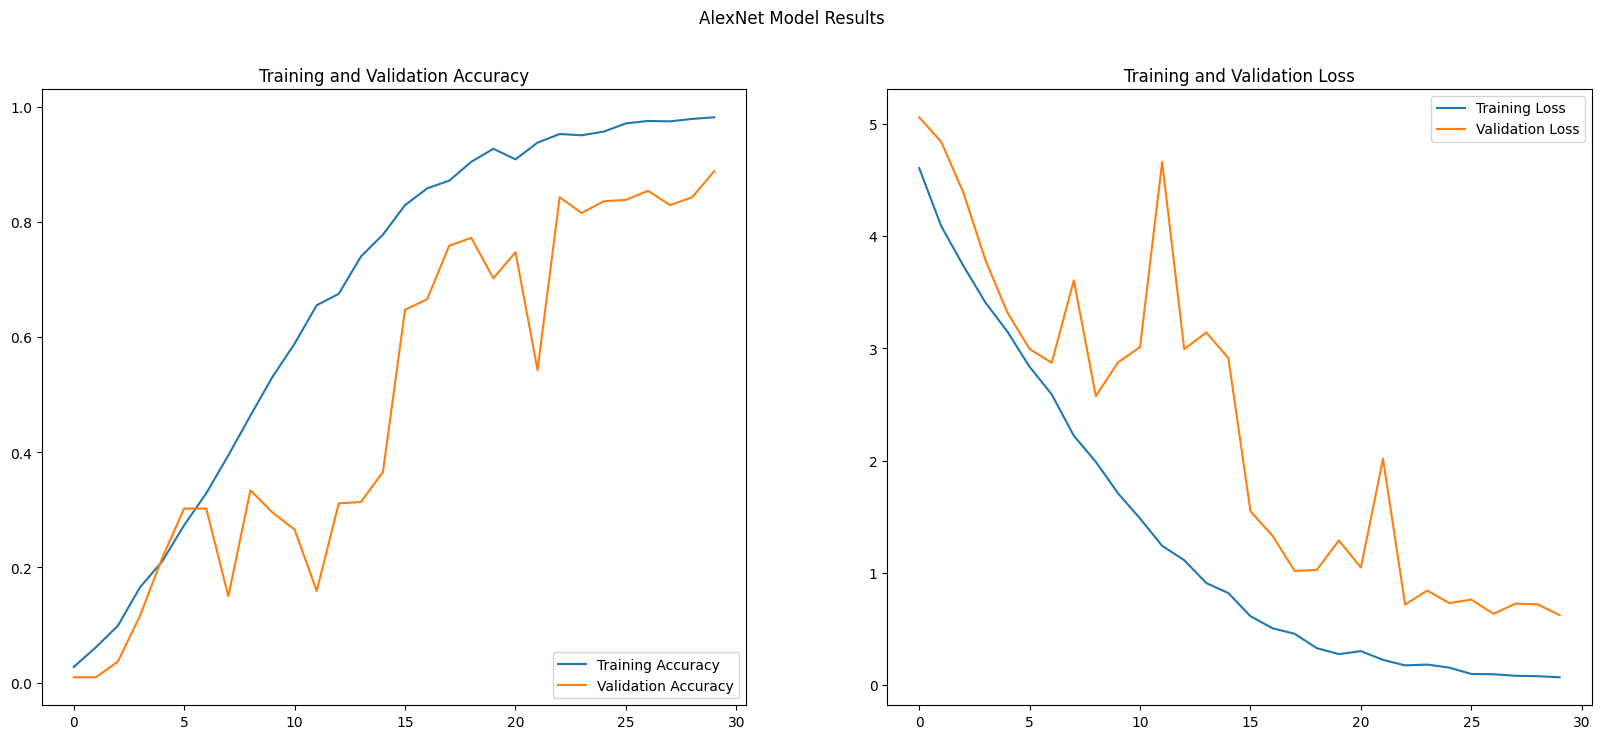

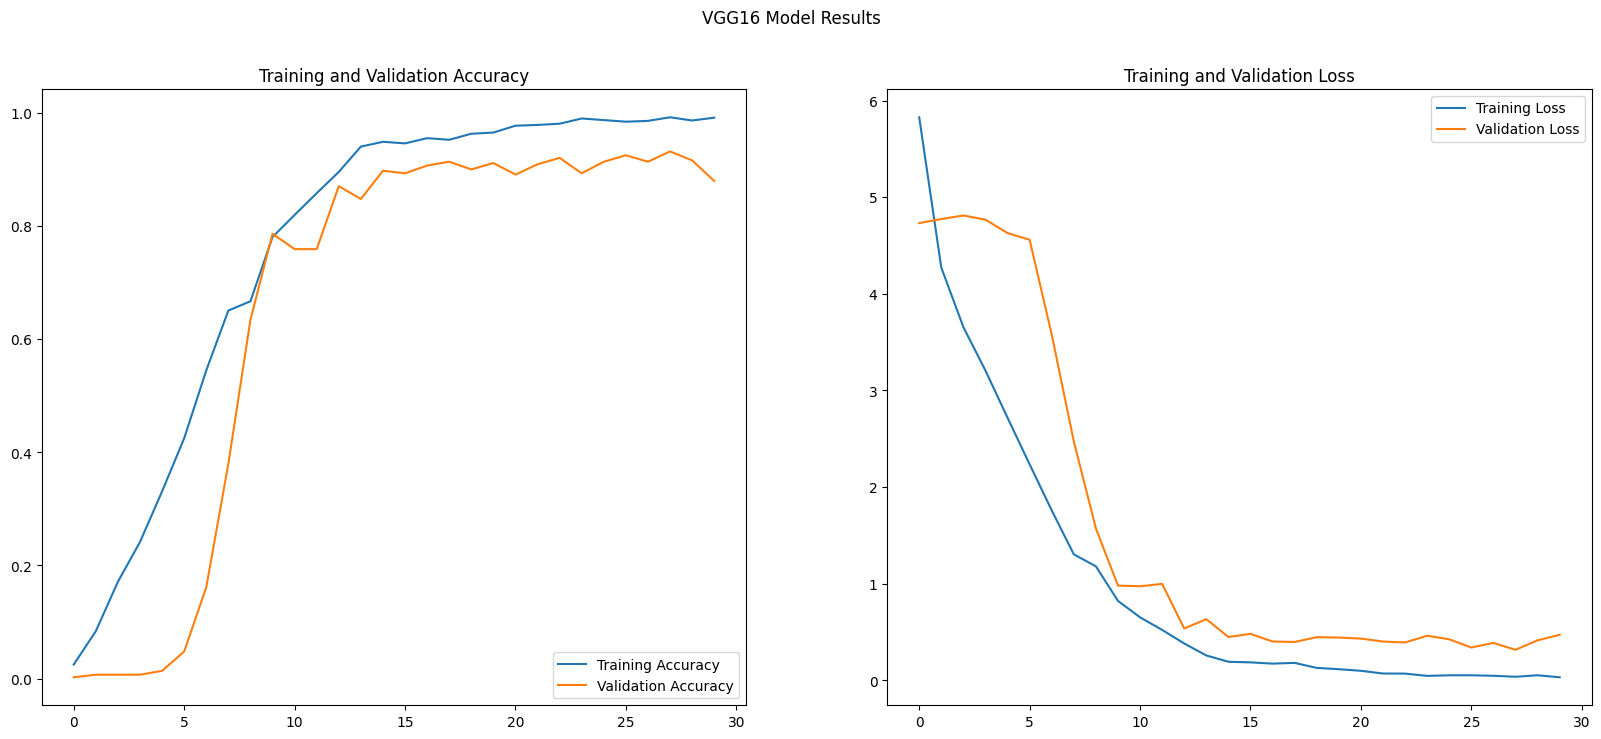

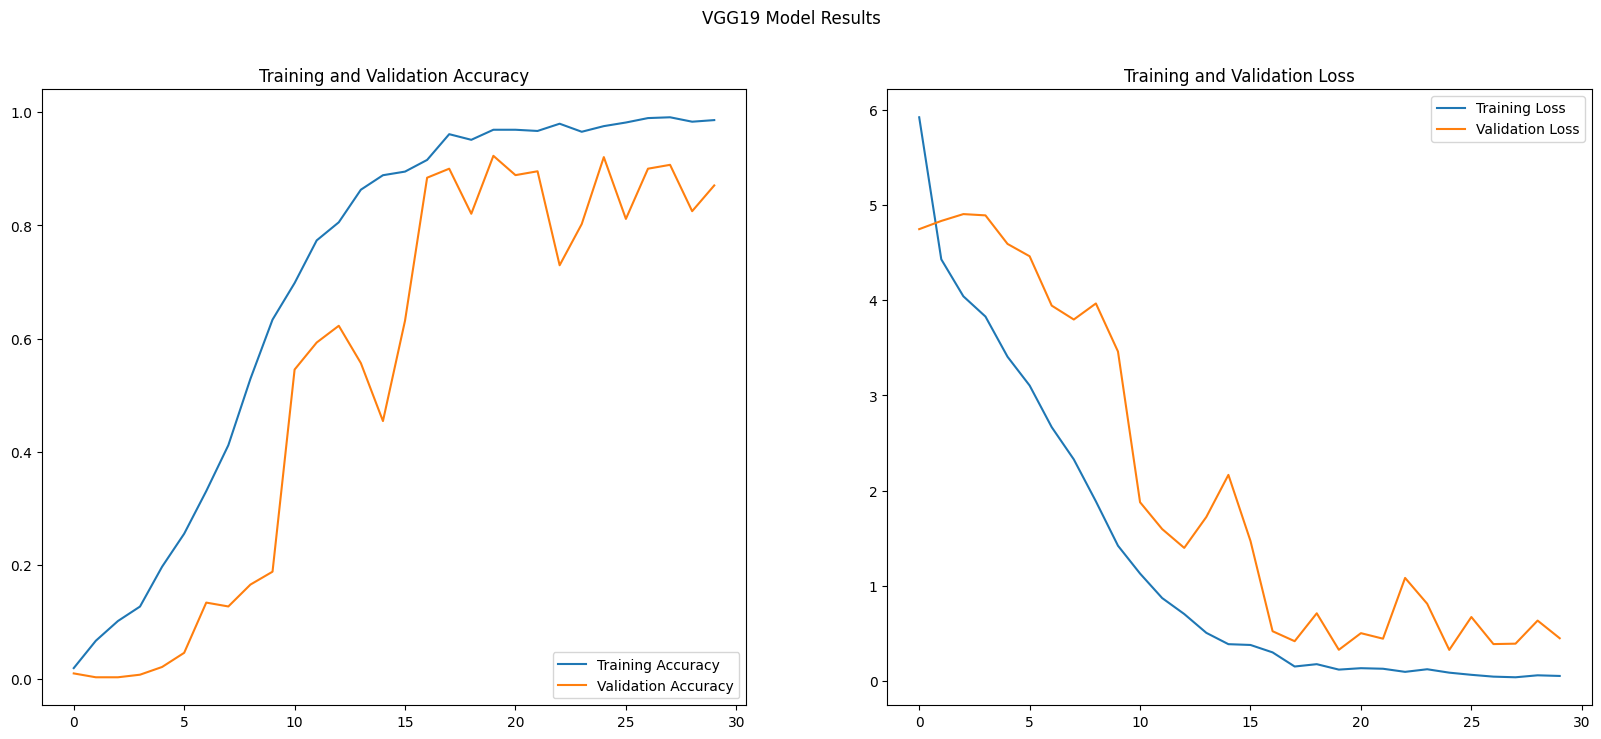

In [17]:
for name, history in model_histories.items():
    plot_model_performance(name, history)

In [20]:
model_results = {}

for name, model in models.items():
    model_results[name] = model.evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {model_results[name][1]*100:.2f}%")
    print(f"Test loss: {model_results[name][0]:.4f}", end = '\n\n')


11/11 [==============================] - 1s 30ms/step - loss: 0.0954 - accuracy: 0.9886
AlexNet Model Results:
Test accuracy: 98.86%
Test loss: 0.0954

11/11 [==============================] - 2s 104ms/step - loss: 0.1485 - accuracy: 0.9489
VGG16 Model Results:
Test accuracy: 94.89%
Test loss: 0.1485

11/11 [==============================] - 2s 86ms/step - loss: 0.1007 - accuracy: 0.9744
VGG19 Model Results:
Test accuracy: 97.44%
Test loss: 0.1007



Saving models and their training histories

In [29]:
for name, model in models.items():
    model.save(f'Saved Models/VERA/{name}-{model_results[name][1]*100:.2f}%.keras')
    print(f'Saved {name} Model')


for name, history in model_histories.items():
    with open(f'Model Histories/VERA/{name}-{model_results[name][1]*100:.2f}%.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved AlexNet Model
Saved VGG16 Model
Saved VGG19 Model


## Loading trained model

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/VERA/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 2200 files belonging to 110 classes.
Using 1760 files for training.
Using 440 files for validation.

Total number of samples in train_dataset: 1408 (44 batches of 32)
Total number of samples in validation_dataset: 448 (14 batches of 32)
Total number of samples in test_dataset: 352 (11 batches of 32)


In [3]:
alexnet_model = keras.models.load_model('Saved Models/VERA/AlexNet-98.86%.keras')
vgg16_model = keras.models.load_model('Saved Models/VERA/VGG16-94.89%.keras')
vgg19_model = keras.models.load_model('Saved Models/VERA/VGG19-97.44%.keras')

Text(0.5, 1.0, 'Predicted Class: 001-M\nActual Class: 001-M')

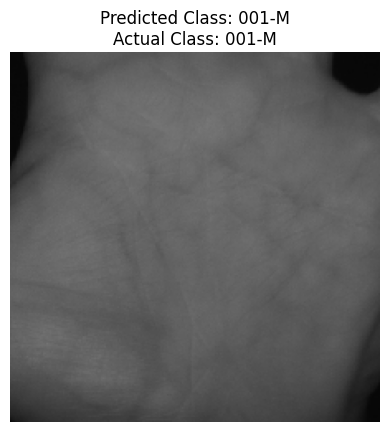

In [6]:
class_to_test = 1 # Try any number from 1 to 110

img = keras.utils.load_img(
    f"Datasets/VERA/{class_names[class_to_test-1]}/01/{class_to_test:03d}_L_1_1.png", target_size=(224, 224)
)
plt.imshow(img)
plt.axis('off')

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

plt.title(f'Predicted Class: {class_names[prediction]}\nActual Class: {class_names[class_to_test-1]}')

In [10]:
def evaluate_dataset(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            # Assign weights based on correct or incorrect recognition
            weight_alexnet = 1 if prediction_alexnet == label else 0
            weight_vgg16 = 1 if prediction_vgg16 == label else 0
            weight_vgg19 = 1 if prediction_vgg19 == label else 0

            # Calculate the final decision
            final_decision = weight_alexnet + weight_vgg16 + weight_vgg19 

            # Update accuracy metrics
            correct_predictions += 1 if final_decision >= 2 else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

accuracy = evaluate_dataset(test_dataset)
print(f"Test Accuracy: {accuracy:.2%}")


Evaluating Dataset With Decision Fusion: 100%|██████████| 11/11 [01:05<00:00,  5.91s/batch]

Test Accuracy: 98.86%


In [6]:
def evaluate_dataset(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Improved Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            predictions_list = [prediction_alexnet, prediction_vgg16, prediction_vgg19]

            joint_decision = max(set(predictions_list), key=predictions_list.count)

            # Update accuracy metrics
            correct_predictions += 1 if joint_decision == label else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

accuracy = evaluate_dataset(test_dataset)
print(f"Test Accuracy: {accuracy:.2%}")


Evaluating Dataset With Improved Decision Fusion: 100%|██████████| 11/11 [01:03<00:00,  5.79s/batch]

Test Accuracy: 99.15%


In [7]:
y = [model.evaluate(test_dataset, verbose=0)[1] for model in [alexnet_model, vgg16_model, vgg19_model]]
y.append(accuracy)

<Axes: >

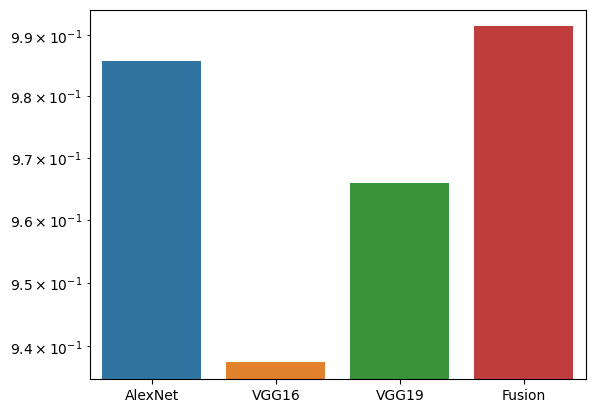

In [8]:
import seaborn as sns

plt.yscale('log')
sns.barplot(y=y, x=['AlexNet', 'VGG16', 'VGG19', 'Fusion'])

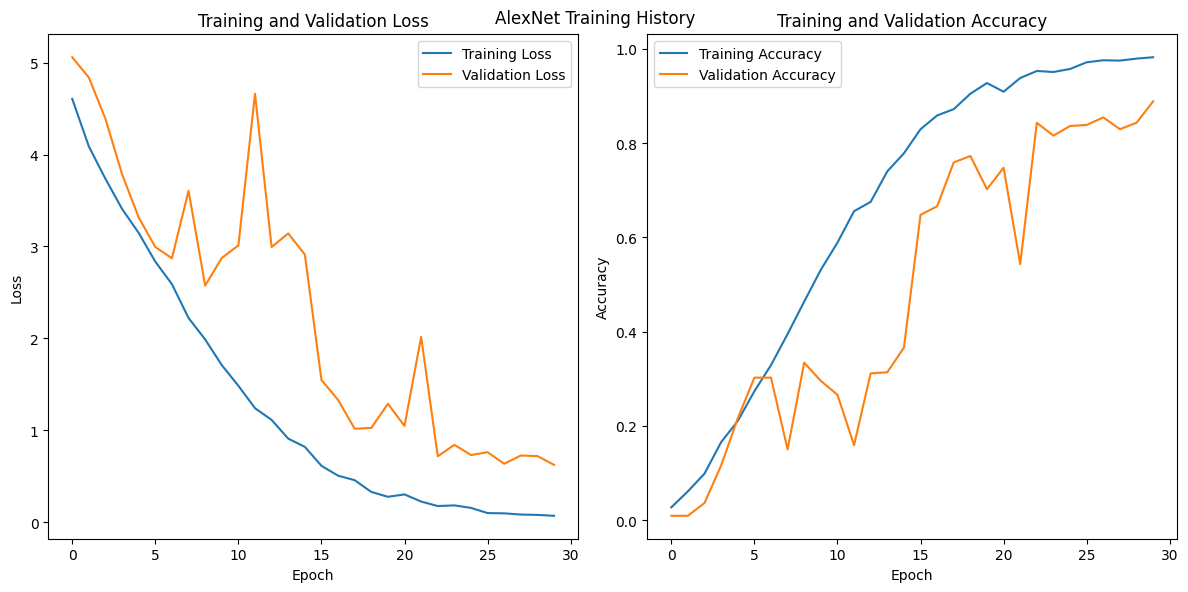

In [27]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/AlexNet-98.86%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('AlexNet Training History')
plt.show()


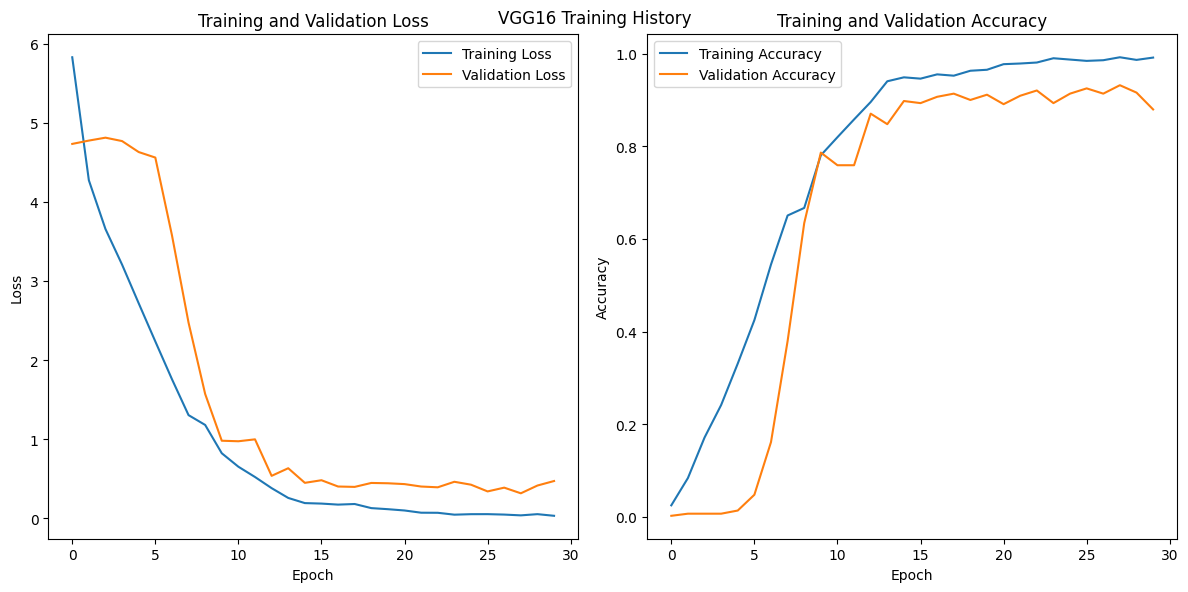

In [28]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/VGG16-94.89%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('VGG16 Training History')
plt.show()


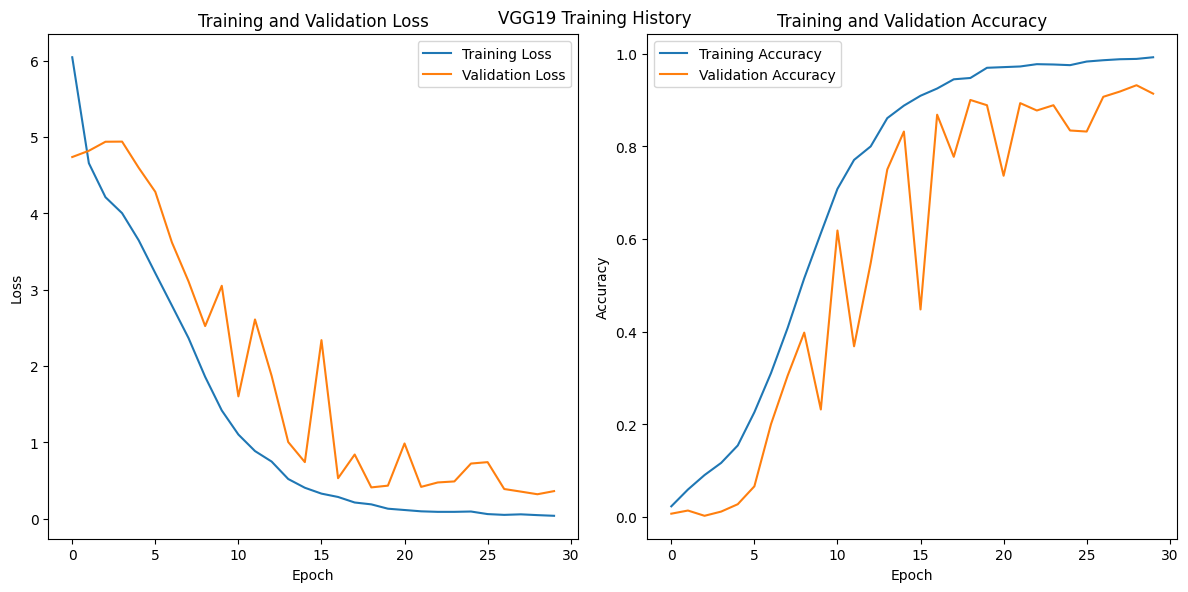

In [3]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/VGG19-99.43%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('VGG19 Training History')
plt.show()
